In [1]:
%load_ext autoreload
%autoreload 2


import datetime as dt
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from meteo_funcs import *

# Meteorological data and crops

## Meteorological inputs

Meteorology is a major factor in determining crop growth. Crop models require meteo inputs to calculate crop development (phenology), carbon assimilation (e.g. photosynthesis) and calculate any stresses (e.g. effect of drought). Accurate and timely sources of meteorological data are hard to come by. Recent developments in the operationalistation of reanalysis datasets (where a climate model is combined with the best observational record to produce an *analysis* of the state of the climate system) now routinely provide global fields of meteorological data. We note that this data is probably inaccurate at small scales, but it's availability means that we can run crop models anywhere.

For these examples, we'll be using the [ERA 5 Reanalysis product](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview) from the [Copernicus Climate Change Service](https://cds.climate.copernicus.eu/cdsapp#!/home) (note that a newer version over land, [ERA5-Land](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land?tab=overview) has also been recently been made available).

The variables of interest for most crop models are:

* Downwelling radiance
* Minimum and maximum daily temperatures
* Vapour pressure
* Wind speed
* Precipitation

It is probably fair to say that estimates of things like precipitation and wind speed will be very local, and the global reanalysis data will look quite different to local *in situ* measurements. Likewise, radiance and temperatures can probably suffer from very local biases due to local orography. These observations suggest that the drivers of our crop model will be **in error** or have some degree of uncertainty associated to them, and this uncertainty will be carried on to the model output.

It also means that all crops within a grid cell will all share the same drivers. Assuming they all share information on crop variety and soils (or have soils parameterised again in error), it means that all crops within a meteo cell will have the same evolution, as the crop model only knows about parameters, meteo and soils! This is clearly very different to what we see in reality, where there is a very large variation of crop evolution and condition even within a single field.

Data assimilation techniques are one way to locally "correct" the crop growth model to track the actual situation that is happening in the field. By using a partial view of the crop (e.g. the LAI, or soil moisture, etc.), we can see whether the prediction from the crop model follows the observations (given their often substantial uncertainty), and then correct the model to track the observations.

Data for all of Africa from years 2010 until 2019 has been provided for you (it is possible to downnload it, but can take a while). In the map below, you can select a location, and after a while, you can visualise the meteorological inputs that are relevant for most crop models:


In [2]:
from ipywidgets import Label
from ipyleaflet import Map

m = Map()

label = Label()
display(label)

def handle_interaction(**kwargs):
    if kwargs.get('type') == 'mousemove':
        label.value = str(kwargs.get('coordinates'))

m.on_interaction(handle_interaction)

m

Label(value='')

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [2]:
from process_meteo_drivers import grab_meteo_data
from concurrent.futures import ThreadPoolExecutor
from functools import partial
meteo_folder = "/data/geospatial_08/ucfajlg/ERA5_meteo"
meteo_files = []
wrapper = lambda year: grab_meteo_data(
        9.2,
        -0.9,
        year,
        f"era5_africa_{year:d}.nc",
        meteo_folder,
        site_name="Ghana")
# create a thread pool of 10 threads

years = np.arange(2010,2019).astype(np.int)
with ThreadPoolExecutor(max_workers=1) as executor:
    for _ in executor.map(wrapper, years):
        pass



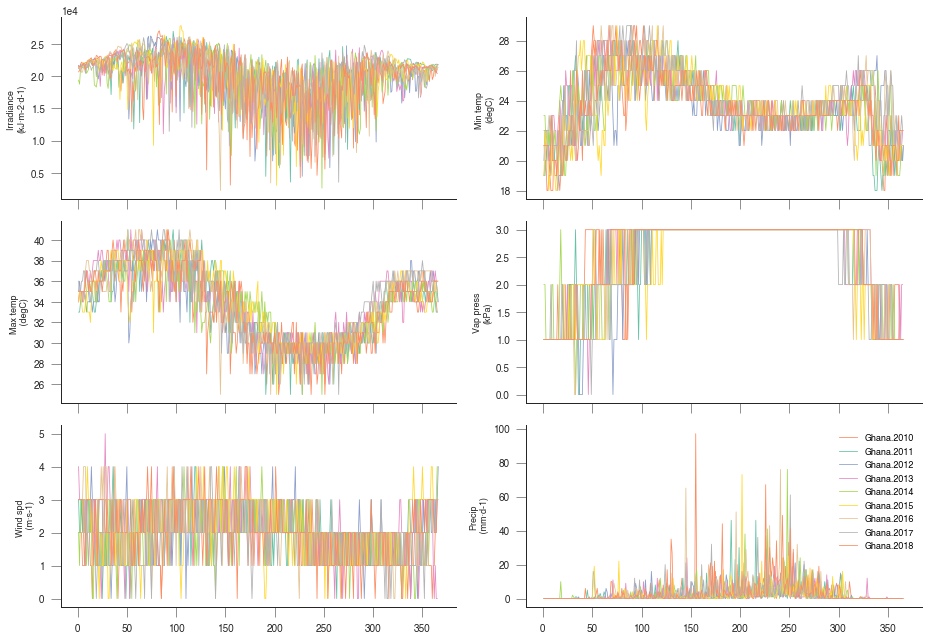

In [2]:
meteo_files = sorted([f for f in Path('./data/').glob("Ghana.20??")])
plot_meteo(meteo_files)

The previous plots are hard to visualise. What's really *going on* there? We can clearly see a temperature seasonality, with cooler temperatures around days of the year 200 to 300. We can also see that the irradiance is very changing, and we can also see that wind speed and vapour pressure deficit are probably not very accurate estimates. Precipitation is also very changing, but it is hard to see any trends. 


## A better way to plot the data

We need to think of a better way to display the data. We can look up [a crop calendar](http://www.fao.org/agriculture/seed/cropcalendar/welcome.do) (or even direct understanding) to see the period where the crop is present. This is an oversimplification, but it's a starting point. We can then think of ways of aggregating the data. The following exercise allows you to plot variables using different starting and ending times.

In [3]:
aggregate_plots();

interactive(children=(SelectionRangeSlider(description='Sowing & Harvest', index=(0, 364), layout=Layout(width…

## The simplest ageometeorological crop model

If we consider that vegetation growth is only limited by water availability, a simple model would basically look at water balance: precipitation minus evapotranspiration. If this balance is positive (more rain than ET), we may initially conclude that in principle, crops will not be stressed by drought. One of the simplest ways to calculate ET is to use a version of Hargreaves equation:

$$
ET_{0} = \frac{0.0023}{\lambda}\cdot \left[T_{max} - T_{min} \right]^{0.5}\cdot R_{surf}\left[T_{mean} - 17.8\right]
$$
where the daily reference evapotranspiration $ET_0$ is given in $[mm\cdot d^{1}]$, $T_{max,min,mean}$ are respectively the daily max, min and mean temperatures in degrees C, $R_{surf}$ is the surface radiance in $kJm^{-2}d^{-1}$ and $\lambda$ is the latent heat of vaporisation. We only chose this equation for its simplicity. More accurate and better methods are the FAO56/Penman-Monteith approach although it depends on wind speed, an unreliable quantity in our reanalysis dataset.